# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
pth1 = '/datasets/faces/labels.csv'
pth2 = 'datasets/faces/labels.csv'
pth3 = 'labels.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    print('Something is wrong')

In [ ]:
df.shape

(7591, 2)

In [ ]:
df.isna().mean()

file_name    0.0
real_age     0.0
dtype: float64

In [ ]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


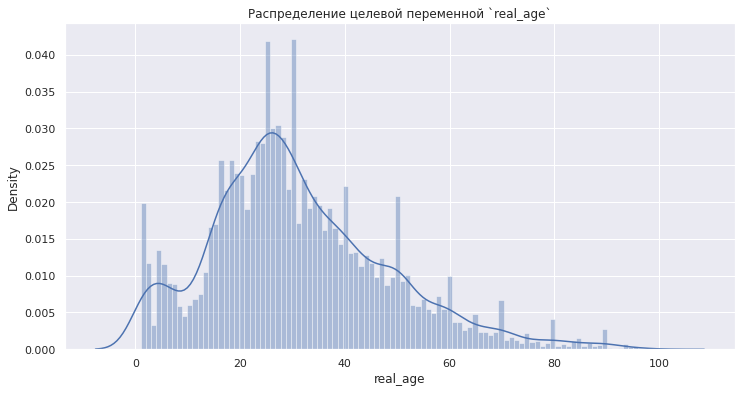

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Распределение целевой переменной `real_age`')
sns.distplot(df['real_age'], bins=100);

In [ ]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=11363)

Found 7591 validated image filenames.


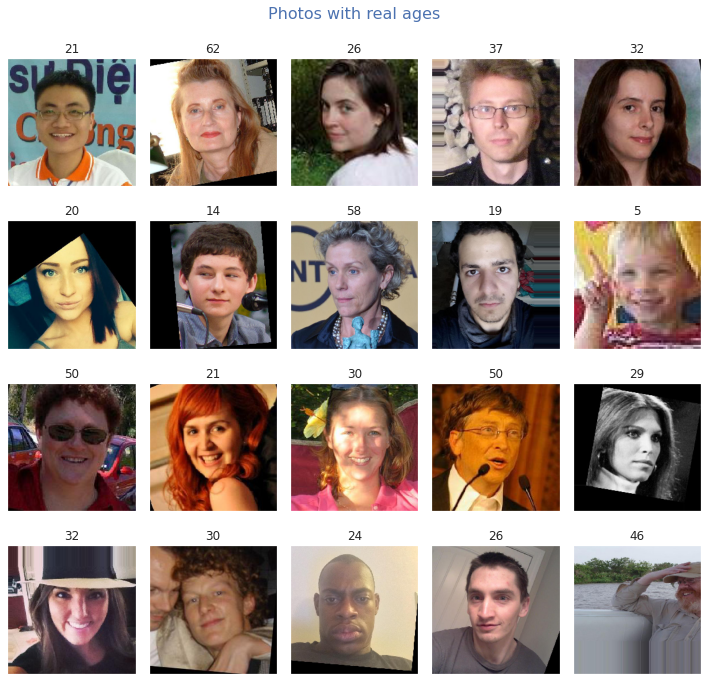

In [ ]:
features, target = next(datagen_flow)

# выводим 20 изображений
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages', fontsize=16, color='b')
    plt.tight_layout()

**Вывод**

- Пропуски в данных отсутствуют, общее количество объектов 7591.
- Объекты имеют изображения лиц людей крупным планом.
- Присутствуют как цветные, так и ч/б фото.
- Часть объектов были изменены (повороты, сдвиги).
- Визуально присвоенные значения целевой переменной корректны.
- Распределение целевой переменной смещено вправо, со средним значением ~ 31, std_dev ~ 17.
- Старшие возрастные категории представлены слабо, что может сказаться на точности предсказаний.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.

```python

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

pth1 = '/datasets/faces/labels.csv'
pth2 = 'datasets/faces/labels.csv'
pth3 = 'labels.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    print('Something is wrong')

def load_train(path):

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=df,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=11363
    )

    return  train_datagen_flow

def load_test(path):

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=df,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=11363
    )

    return  test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=(test_data),
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 266s - loss: 215.1534 - mae: 10.5490 - val_loss: 490.7876 - val_mae: 17.1103
Epoch 2/10
178/178 - 40s - loss: 83.2762 - mae: 6.9179 - val_loss: 600.7866 - val_mae: 19.4803
Epoch 3/10
178/178 - 39s - loss: 61.9167 - mae: 6.0037 - val_loss: 251.2433 - val_mae: 11.8850
Epoch 4/10
178/178 - 39s - loss: 43.9000 - mae: 5.0812 - val_loss: 162.8090 - val_mae: 9.2480
Epoch 5/10
178/178 - 40s - loss: 34.4909 - mae: 4.4896 - val_loss: 97.8881 - val_mae: 7.4791
Epoch 6/10
178/178 - 39s - loss: 27.8894 - mae: 4.0561 - val_loss: 72.0007 - val_mae: 6.2909
Epoch 7/10
178/178 - 40s - loss: 22.3900 - mae: 3.6107 - val_loss: 66.7489 - val_mae: 6.0898
Epoch 8/10
178/178 - 41s - loss: 18.4186 - mae: 3.2975 - val_loss: 78.0753 - val_mae: 6.5027
Epoch 9/10
178/178 - 42s - loss: 15.1620 - mae: 2.9729 - val_loss: 72.7897 - val_mae: 6.3514
Epoch 10/10
178/178 - 43s - loss: 12.4361 - mae: 2.6835 - val_loss: 64.5736 - val_mae: 5.9781
60/60 - 10s - loss: 64.5736 - mae: 5.9781
Test MAE: 5.9781
```

## Анализ обученной модели

- Была использована архитектура предобученной модели ResNet50 (backbone + head).
- Размер батча 32, 10 эпох, оптимизатор Adam с применением аугментации отражения по горизонтали.


NN с архитектурой ResNet50 позволила получить значение метрики MAE на тестовой выборке 5.92.
- Результаты достаточны для определения возрастной группы покупателя и последующего продвижения товаров.
- Использовать модель для проверки добросоветности продавцов в части законности реализации алкогольной продукции может быть затруднительно.